In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from arch.univariate import ConstantMean, GARCH, Normal

import arch
print(arch.__version__)

7.2.0


In [36]:
aval_prices = pd.read_parquet('../data/price_data/processed/aval_processed_data.parquet')
avax1_features = pd.read_parquet('../data/on_chain_data/processed/avax1_chain_processed.parquet')
avax2_features = pd.read_parquet('../data/on_chain_data/processed/avax2_chain_processed.parquet')
avax_tech = pd.read_parquet('../data/data_segmented_tech/avax_data.parquet')

In [37]:
common_columns = avax1_features.columns
avax2_features = avax2_features[common_columns]
avax_features = pd.concat([avax1_features, avax2_features], ignore_index=True)

In [38]:
aval_prices['time_close'] = pd.to_datetime(aval_prices['time_close'])
aval_prices.set_index('time_close', inplace=True)
aval_prices.index = aval_prices.index.tz_localize('UTC')

In [39]:
common_length = min(len(aval_prices), len(avax_features))
aval_prices_aligned = aval_prices.iloc[:common_length].copy()
avax_features_aligned = avax_features.iloc[:common_length].copy()
avax_features_aligned.index = aval_prices_aligned.index

In [40]:
lag_cols = ['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']
avax_features_aligned[lag_cols] = avax_features_aligned[lag_cols].shift(1)

In [41]:
data = avax_features_aligned.join(aval_prices_aligned[['price_close']], how='inner')

In [42]:
common_length_tech = min(len(avax_tech), len(aval_prices_aligned))
avax_tech_aligned = avax_tech.iloc[:common_length_tech].copy()
avax_tech_aligned.index = aval_prices_aligned.index[:common_length_tech]

tech_cols = ['fib_23', 'fib_38', 'fib_50', 'fib_61', 'fib_78', 'bollinger', 'EMAcross', 'RSI']
avax_tech_renamed = avax_tech_aligned[tech_cols].rename(columns=lambda x: "tech_" + x)

data = data.join(avax_tech_renamed, how='left')

tech_cols_renamed = ["tech_" + col for col in tech_cols]
feature_cols = lag_cols + tech_cols_renamed

In [83]:
"""data['price_diff'] = data['price_close'].diff()
threshold = data['price_diff'].std()

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data['Signal'] = data['price_diff'].apply(lambda x: get_signal(x, threshold))"""

def estimate_dcc_lambda(raw_signal, asset_returns):
    """
    Estimate the effective decay factor (lambda) for EWMA smoothing by fitting a DCC model.
    
    Parameters:
        raw_signal (pd.Series): The raw trading signal (e.g., long probability minus short probability).
        asset_returns (pd.Series): The asset returns series.
        
    Returns:
        lambda_est (float): The effective decay parameter estimated as a + b.
        dcc_result: The fitted DCC model result (for inspection if needed).
    """
    # Fit a univariate GARCH(1,1) model to the raw_signal.
    am_signal = ConstantMean(raw_signal)
    am_signal.volatility = GARCH(1, 0, 1)
    am_signal.distribution = Normal()
    res_signal = am_signal.fit(disp='off')
    
    # Fit a univariate GARCH(1,1) model to the asset_returns.
    am_returns = ConstantMean(asset_returns)
    am_returns.volatility = GARCH(1, 0, 1)
    am_returns.distribution = Normal()
    res_returns = am_returns.fit(disp='off')
    
    # Combine the standardized residuals from both models.
    std_resid = pd.concat([res_signal.std_resid, res_returns.std_resid], axis=1)
    std_resid.columns = ['signal', 'returns']
    
    # Fit the DCC model on the two series.
    dcc = DynamicConditionalCorrelation(std_resid)
    dcc_result = dcc.fit()
    
    # Extract the DCC parameters.
    # The DCC model typically estimates parameters 'a' and 'b' for the updating equation:
    # Q_t = (1 - a - b) * Q_bar + a * (e_{t-1}e_{t-1}') + b * Q_{t-1}
    a = dcc_result.params['a']
    b = dcc_result.params['b']
    lambda_est = a + b
    return lambda_est, dcc_result

# =============================================================================
# Example usage:
# Assume you have already computed:
#   y_pred  -> the model's predicted probabilities (shape: n_samples x 3)
#   asset_returns -> a numpy array of asset returns corresponding to your test period.
#
# For the raw signal, we assume:
#   raw_signal = y_pred[:, 0] - y_pred[:, 2]
# =============================================================================

# (Here, replace these with your actual arrays.)
# For demonstration, we'll create dummy data:
np.random.seed(42)
n_samples = 500
raw_signal_arr = np.random.randn(n_samples)  # This would be your raw signal
asset_returns_arr = np.random.randn(n_samples) * 0.01  # Simulated asset returns

# Convert to pandas Series (ensure they have a datetime index if needed).
raw_signal_series = pd.Series(raw_signal_arr)
asset_returns_series = pd.Series(asset_returns_arr)

# Estimate the effective lambda using DCC.
lambda_est, dcc_result = estimate_dcc_lambda(raw_signal_series, asset_returns_series)
print("Estimated lambda (decay factor) from DCC:", lambda_est)

# =============================================================================
# Now define a get_signal function that uses EWMA with the estimated lambda.
# In pandas.ewm, you can specify the decay via the 'alpha' parameter.
# One common relationship is to set: alpha = lambda_est.
# (Alternatively, you might use alpha = 1 - lambda_est depending on your convention.)
# =============================================================================

def get_signal(y_pred, alpha):
    """
    Compute the EWMA-smoothed trading signal.
    
    Parameters:
        y_pred (np.ndarray): Array of shape (n_samples, n_classes) with predicted probabilities.
                             Assumes column 0 is long and column 2 is short.
        alpha (float): The EWMA smoothing parameter.
        
    Returns:
        np.ndarray: Smoothed signal.
    """
    # Compute raw signal.
    raw_signal = y_pred[:, 0] - y_pred[:, 2]
    # Smooth using EWMA.
    signal_series = pd.Series(raw_signal)
    smoothed_signal = signal_series.ewm(alpha=alpha, adjust=False).mean().values
    return smoothed_signal

# =============================================================================
# Example: using the get_signal function with the estimated lambda.
# (In practice, replace y_pred_example with your model's predictions.)
# =============================================================================

# Dummy predicted probabilities for demonstration.
y_pred_example = np.random.rand(n_samples, 3)
# Normalize to sum to one.
y_pred_example = y_pred_example / y_pred_example.sum(axis=1, keepdims=True)

smoothed_signal = get_signal(y_pred_example, alpha=lambda_est)
print("First 10 values of the smoothed signal using EWMA with estimated lambda:")
print(smoothed_signal[:10])


NameError: name 'ConstantMean' is not defined

In [44]:
data = data.dropna()
data = data.sort_index()

In [45]:
cutoff = int(len(data) * 0.7)
train_data = data.iloc[:cutoff]
test_data  = data.iloc[cutoff:]

features_train = train_data[feature_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))
print("Data shape:", data.shape)
print(data['Signal'].value_counts())
print("Data shape after join:", data.shape)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

Number of training samples: 26907
Data shape: (38439, 16)
Signal
Hold    32901
Sell     2785
Buy      2753
Name: count, dtype: int64
Data shape after join: (38439, 16)


In [46]:
data['price_diff'] = data['price_close'].diff()
threshold = data['price_diff'].std()

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data['Signal'] = data['price_diff'].apply(lambda x: get_signal(x, threshold))

data = data.dropna()
data = data.sort_index()

c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_333 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_222 (LeakyReLU)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_223 (LeakyReLU)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,203 (12.51 KB)

 Trainable params: 3,203 (12.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6215 - loss: 101611.6094 - val_accuracy: 0.9819 - val_loss: 3695.0669
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6249 - loss: 19589.8672 - val_accuracy: 0.9819 - val_loss: 4708.2124
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6470 - loss: 25027.8652 - val_accuracy: 0.9819 - val_loss: 3250.8557
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6370 - loss: 18756.7129 - val_accuracy: 0.9743 - val_loss: 1772.5697
Epoch 5/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6375 - loss: 24147.3242 - val_accuracy: 0.9819 - val_loss: 4094.8259
Epoch 6/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6420 - loss: 15484.5615 - val_accuracy: 0.9819 - val_loss: 2180.0476
Epoch 7/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6360 - loss: 16487.9531 - val_accuracy: 0.9819 - val_loss: 4093.8301
Epoch 8/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

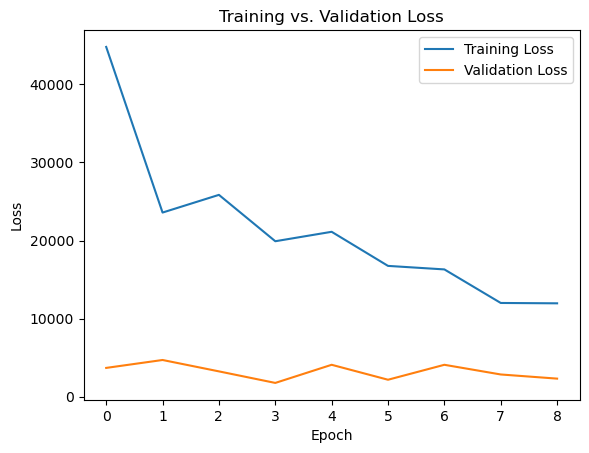

In [55]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

optimal_epochs = len(history.history['loss'])
print("Optimal number of epochs:", optimal_epochs)

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [ ]:
X = data.drop('Signal', axis=1).values
y = data['Signal'].values

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(integer_encoded)

min_train_size = int(0.5 * len(X))
min_test_size = int(0.1 * len(X))

step = 1500
split_indices = range(min_train_size, len(X) - min_test_size + 1, step)


val_accuracies = []
train_intervals = []
test_intervals = []

total_splits = len(split_indices)
print(f"Total splits: {total_splits}")

for n, split_index in enumerate(split_indices, start=1):

    print(f"{n}/{total_splits} splits tested")
    
    X_train = X[:split_index]
    y_train = y_cat[:split_index]
    X_test = X[split_index:]
    y_test = y_cat[split_index:]
    
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64),
        LeakyReLU(negative_slope=0.1),
        Dense(32),
        LeakyReLU(negative_slope=0.1),
        Dense(y_cat.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=0
    )
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy = scores[1]
    val_accuracies.append(accuracy)
    
    train_intervals.append((0, split_index - 1))
    test_intervals.append((split_index, len(X) - 1))

best_index = np.argmax(val_accuracies)
print("Summary of candidate intervals:")
for i, (train_int, test_int) in enumerate(zip(train_intervals, test_intervals)):
    print(f"Split {i+1}: Training indices: {train_int}, Testing indices: {test_int}, Accuracy: {val_accuracies[i]*100:.2f}%")

print("\nBest training interval:")
print(f"Training indices: {train_intervals[best_index]}")
print(f"Testing indices:  {test_intervals[best_index]}")
print(f"Test accuracy: {val_accuracies[best_index]*100:.2f}%")

Total splits: 11
1/11 splits tested
2/11 splits tested
3/11 splits tested
4/11 splits tested
5/11 splits tested
6/11 splits tested
7/11 splits tested
8/11 splits tested
9/11 splits tested
10/11 splits tested
11/11 splits tested
Summary of candidate intervals:
Split 1: Training indices: (0, 19218), Testing indices: (19219, 38437), Accuracy: 80.93%
Split 2: Training indices: (0, 20718), Testing indices: (20719, 38437), Accuracy: 91.14%
Split 3: Training indices: (0, 22218), Testing indices: (22219, 38437), Accuracy: 91.72%
Split 4: Training indices: (0, 23718), Testing indices: (23719, 38437), Accuracy: 91.58%
Split 5: Training indices: (0, 25218), Testing indices: (25219, 38437), Accuracy: 90.65%
Split 6: Training indices: (0, 26718), Testing indices: (26719, 38437), Accuracy: 68.56%
Split 7: Training indices: (0, 28218), Testing indices: (28219, 38437), Accuracy: 89.86%
Split 8: Training indices: (0, 29718), Testing indices: (29719, 38437), Accuracy: 68.53%
Split 9: Training indices: (

In [60]:
Optimal_Training_Length = train_intervals[best_index][1]
Optimal_Testing_Start = test_intervals[best_index][0]
Optimal_Testing_End = test_intervals[best_index][1]
train_data = data.iloc[:Optimal_Training_Length]
test_data  = data.iloc[Optimal_Testing_Start:Optimal_Testing_End]

features_train = train_data[feature_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

Number of training samples: 22218


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_390 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_260 (LeakyReLU)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_261 (LeakyReLU)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_392 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7387 - loss: 0.6630 - val_accuracy: 0.9908 - val_loss: 0.0635
Epoch 2/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7611 - loss: 0.5775 - val_accuracy: 0.9908 - val_loss: 0.0606
Epoch 3/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7626 - loss: 0.5716 - val_accuracy: 0.9908 - val_loss: 0.0625
Epoch 4/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7590 - loss: 0.5733 - val_accuracy: 0.9908 - val_loss: 0.0651
Epoch 5/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7549 - loss: 0.5626 - val_accuracy: 0.9908 - val_loss: 0.0654
Epoch 6/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7622 - loss: 0.5588 - val_accuracy: 0.9908 - val_loss: 0.0642
Epoch 7/100
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7585 - loss: 0.5701 - val_accuracy: 0.9908 - val_loss: 0.0633
Optimal number of epochs: 7


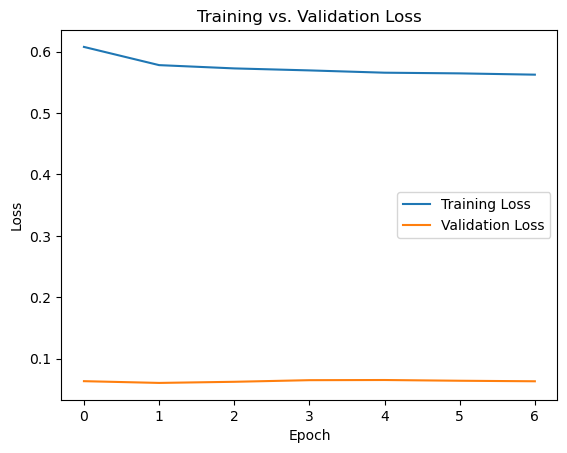

In [61]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

optimal_epochs = len(history.history['loss'])
print("Optimal number of epochs:", optimal_epochs)

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


In [62]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2)

Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_393 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_262 (LeakyReLU)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_263 (LeakyReLU)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7441 - loss: 0.6549 - val_accuracy: 0.9908 - val_loss: 0.0641
Epoch 2/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7594 - loss: 0.5768 - val_accuracy: 0.9908 - val_loss: 0.0600
Epoch 3/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7563 - loss: 0.5715 - val_accuracy: 0.9908 - val_loss: 0.0614
Epoch 4/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7665 - loss: 0.5576 - val_accuracy: 0.9908 - val_loss: 0.0598
Epoch 5/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7715 - loss: 0.5493 - val_accuracy: 0.9908 - val_loss: 0.0594
Epoch 6/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7611 - loss: 0.5619 - val_accuracy: 0.9908 - val_loss: 0.0600
Epoch 7/7
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7566 - loss: 0.5689 - val_accuracy: 0.9908 - val_loss: 0.0607


130/507 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step

C:\Users\matth\AppData\Local\Temp\ipykernel_13056\125453714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step

Trading Performance on Test Data:
Total PnL (percentage): 0.01%
Absolute PnL: $5.13
Annualized Sharpe Ratio: 0.0983


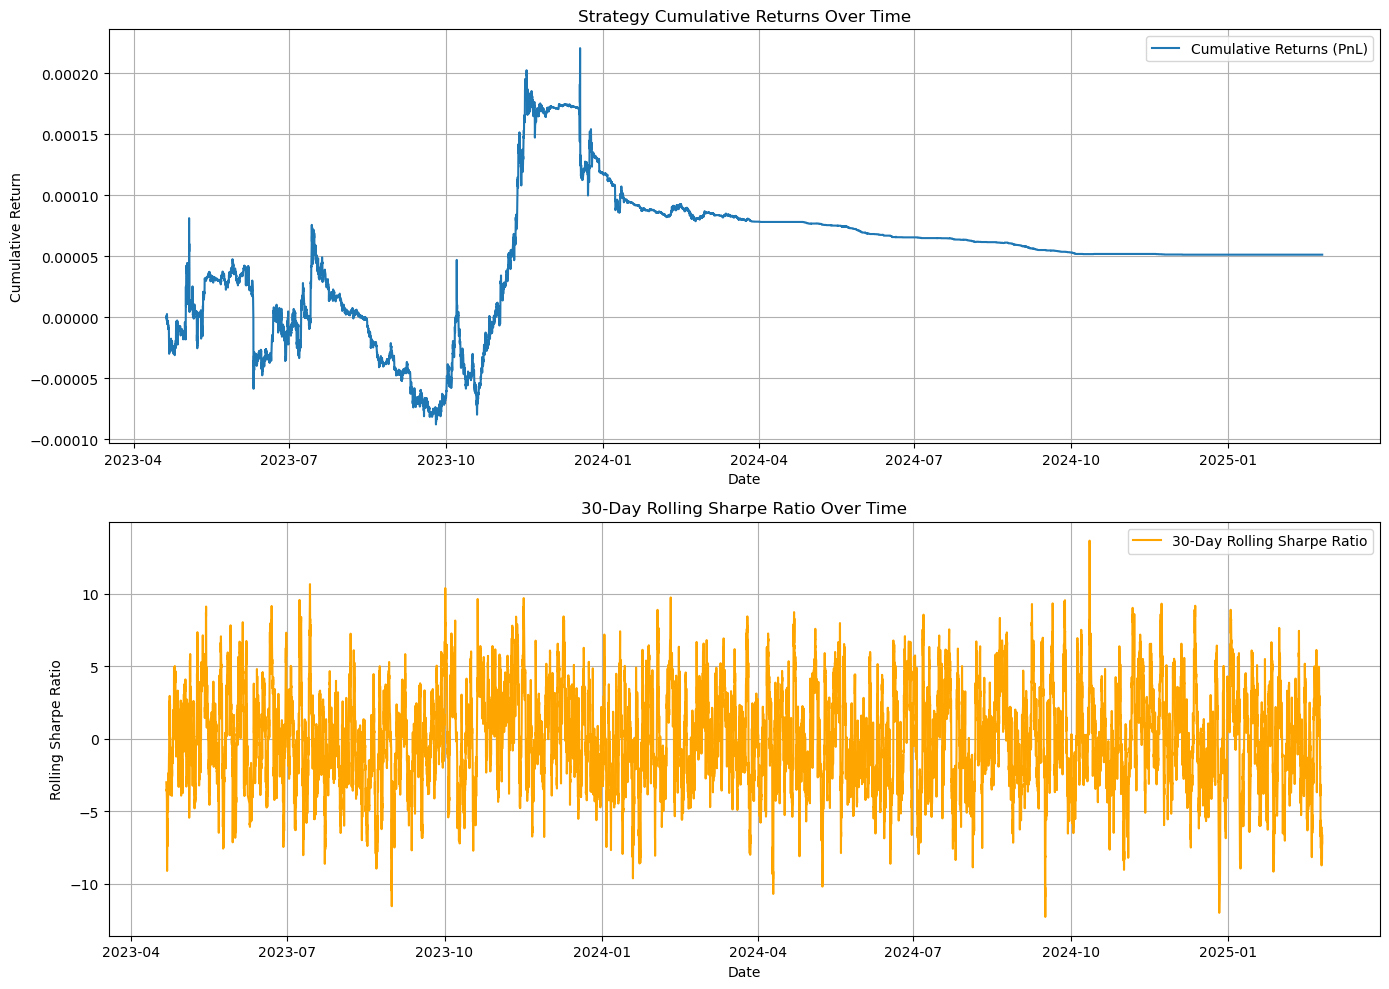

In [63]:
test_data['asset_return'] = test_data['price_close'].pct_change()
test_data = test_data.dropna()

features_test_aligned = test_data[feature_cols].values
X_test_aligned = scaler.transform(features_test_aligned)
y_pred_test_aligned = model.predict(X_test_aligned)
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = test_data['asset_return'].values.astype(np.float32)
strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]
sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)

initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data:")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))

dates = test_data.index
cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)
returns_series = pd.Series(strategy_returns_test, index=dates)

window = 30
rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Number of training samples: 22218
Training run 1/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training run 2/10
Training run 3/10
Training run 4/10
Training run 5/10
Training run 6/10
Training run 7/10
Training run 8/10
Training run 9/10
Training run 10/10
Test Loss (averaged model): 0.9274, Test Accuracy (averaged model): 0.9233
 42/507 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

C:\Users\matth\AppData\Local\Temp\ipykernel_13056\3908286943.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step

Trading Performance on Test Data:
Total PnL (percentage): -0.76%
Absolute PnL: $-761.95
Annualized Sharpe Ratio: -0.1313


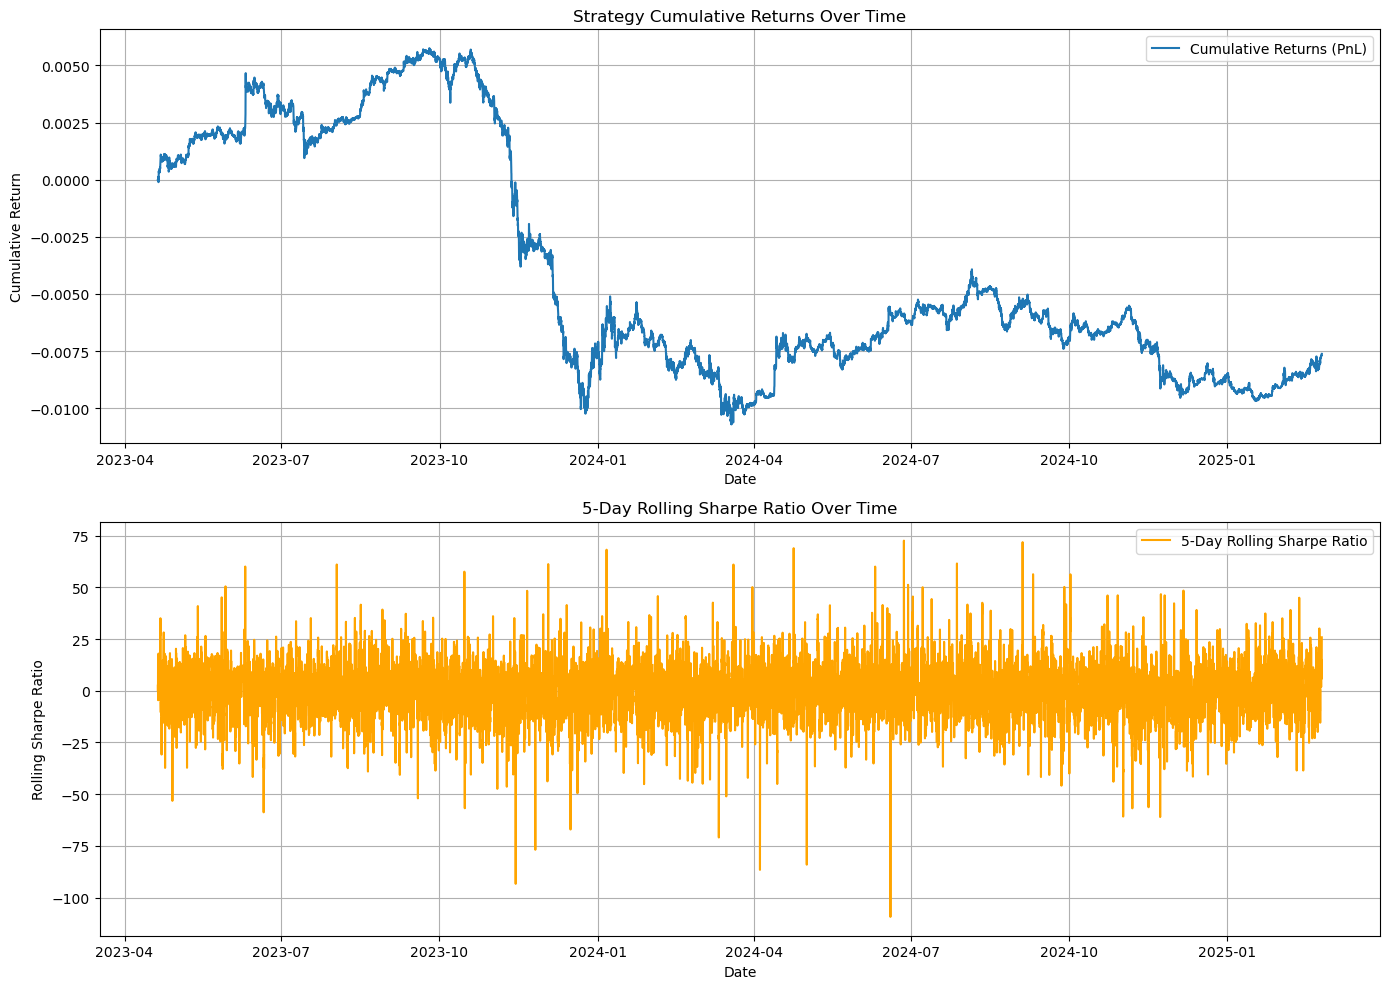

In [65]:
train_data = data.iloc[:Optimal_Training_Length]
test_data  = data.iloc[Optimal_Testing_Start:Optimal_Testing_End]

features_train = train_data[feature_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

features_test = test_data[feature_cols].values
labels_test = test_data['Signal'].values
integer_encoded_test = label_encoder.transform(labels_test)
y_test = to_categorical(integer_encoded_test)
X_test = scaler.transform(features_test)

def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1],)

num_runs = 10
all_weights = []

for run in range(num_runs):
    print(f"Training run {run+1}/{num_runs}")
    model_run = create_model(input_shape)
    model_run.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2, verbose=0)
    all_weights.append(model_run.get_weights())

average_weights = []
for weights_tuple in zip(*all_weights):
    avg_weight = np.mean(np.array(weights_tuple), axis=0)
    average_weights.append(avg_weight)

avg_model = create_model(input_shape)
avg_model.set_weights(average_weights)

loss, accuracy = avg_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss (averaged model): {:.4f}, Test Accuracy (averaged model): {:.4f}".format(loss, accuracy))

test_data['asset_return'] = test_data['price_close'].pct_change()
strategy_data = test_data.dropna().copy()

features_test_aligned = strategy_data[feature_cols].values
X_test_aligned = scaler.transform(features_test_aligned)

y_pred_test_aligned = avg_model.predict(X_test_aligned)
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = strategy_data['asset_return'].values.astype(np.float32)
strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]
sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)
initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data:")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))

dates = strategy_data.index
cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)
returns_series = pd.Series(strategy_returns_test, index=dates)

window = 5
rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Assume the following variables are defined:
# - data: your full DataFrame
# - feature_cols: list of feature column names
# - Optimal_Training_Length, Optimal_Testing_Start, Optimal_Testing_End: indices for splitting

# Split the data into training and testing segments.
train_data = data.iloc[:Optimal_Training_Length]
test_data  = data.iloc[Optimal_Testing_Start:Optimal_Testing_End]

# Prepare training data.
features_train = train_data[feature_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

# Prepare test data.
features_test = test_data[feature_cols].values
labels_test = test_data['Signal'].values
integer_encoded_test = label_encoder.transform(labels_test)
y_test = to_categorical(integer_encoded_test)
X_test = scaler.transform(features_test)

def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(96),
        LeakyReLU(alpha=0.16),  # You could also use negative_slope=0.1
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1],)
optimal_epochs = 15  # Set this based on your earlier experiments

num_runs = 10

# Lists to store performance metrics for each run.
total_pnl_list = []
absolute_pnl_list = []
sharpe_ratio_list = []

for run in range(num_runs):
    print(f"\nTraining run {run+1}/{num_runs}")
    
    # Create and train a new model.
    model_run = create_model(input_shape)
    model_run.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2, verbose=0)
    
    # Optionally, evaluate the model on the test set for classification performance.
    loss, accuracy = model_run.evaluate(X_test, y_test, verbose=0)
    print(f"Run {run+1}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    
    # Evaluate trading performance.
    # Copy test_data so the original DataFrame is not modified.
    test_data_run = test_data.copy()
    test_data_run['asset_return'] = test_data_run['price_close'].pct_change()
    strategy_data = test_data_run.dropna().copy()
    
    # Prepare features from strategy_data and scale them.
    features_test_aligned = strategy_data[feature_cols].values
    X_test_aligned = scaler.transform(features_test_aligned)
    
    # Get predictions from the model.
    y_pred_test_aligned = model_run.predict(X_test_aligned)
    
    # Create a position signal:
    # For example, long probability (class 0) minus short probability (class 2).
    positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]
    
    # Compute strategy returns.
    asset_returns_test = strategy_data['asset_return'].values.astype(np.float32)
    # Shift positions by one to avoid lookahead bias.
    strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
    strategy_returns_test[0] = 0  # First return is set to zero.
    
    cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
    total_pnl_percentage = cumulative_returns_test[-1]
    
    # Compute annualized Sharpe ratio.
    if np.std(strategy_returns_test) != 0:
        sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)
    else:
        sharpe_ratio_test = 0
        
    initial_capital = 100000
    absolute_pnl_test = total_pnl_percentage * initial_capital
    
    print("Run {} Trading Performance:".format(run+1))
    print("  Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
    print("  Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
    print("  Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))
    
    # Append the metrics.
    total_pnl_list.append(total_pnl_percentage)
    absolute_pnl_list.append(absolute_pnl_test)
    sharpe_ratio_list.append(sharpe_ratio_test)

# Calculate average metrics over all runs.
avg_total_pnl = np.mean(total_pnl_list)
avg_absolute_pnl = np.mean(absolute_pnl_list)
avg_sharpe_ratio = np.mean(sharpe_ratio_list)

print("\nAverage Trading Performance over {} runs:".format(num_runs))
print("  Average Total PnL (percentage): {:.2%}".format(avg_total_pnl))
print("  Average Absolute PnL: ${:,.2f}".format(avg_absolute_pnl))
print("  Average Annualized Sharpe Ratio: {:.4f}".format(avg_sharpe_ratio))


Number of training samples: 22218

Training run 1/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 1: Test Loss: 1.1267, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step
Run 1 Trading Performance:
  Total PnL (percentage): -0.00%
  Absolute PnL: $-1.06
  Annualized Sharpe Ratio: 0.1850

Training run 2/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 2: Test Loss: 1.0513, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
Run 2 Trading Performance:
  Total PnL (percentage): 0.03%
  Absolute PnL: $32.13
  Annualized Sharpe Ratio: 0.3409

Training run 3/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 3: Test Loss: 1.1889, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
Run 3 Trading Performance:
  Total PnL (percentage): 0.01%
  Absolute PnL: $14.96
  Annualized Sharpe Ratio: 0.2770

Training run 4/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 4: Test Loss: 1.2220, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
Run 4 Trading Performance:
  Total PnL (percentage): -0.01%
  Absolute PnL: $-6.31
  Annualized Sharpe Ratio: -0.1055

Training run 5/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 5: Test Loss: 1.1244, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
Run 5 Trading Performance:
  Total PnL (percentage): 0.00%
  Absolute PnL: $0.15
  Annualized Sharpe Ratio: 0.0539

Training run 6/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 6: Test Loss: 1.2782, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
Run 6 Trading Performance:
  Total PnL (percentage): -0.00%
  Absolute PnL: $-3.50
  Annualized Sharpe Ratio: 0.0239

Training run 7/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 7: Test Loss: 1.2223, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Run 7 Trading Performance:
  Total PnL (percentage): -0.01%
  Absolute PnL: $-9.56
  Annualized Sharpe Ratio: -0.0515

Training run 8/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 8: Test Loss: 1.2359, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
Run 8 Trading Performance:
  Total PnL (percentage): 0.01%
  Absolute PnL: $9.54
  Annualized Sharpe Ratio: 0.2868

Training run 9/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 9: Test Loss: 1.2728, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
Run 9 Trading Performance:
  Total PnL (percentage): -0.00%
  Absolute PnL: $-0.14
  Annualized Sharpe Ratio: 0.1822

Training run 10/10


c:\Users\matth\AnacondaDist\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Run 10: Test Loss: 1.1524, Test Accuracy: 0.9233
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
Run 10 Trading Performance:
  Total PnL (percentage): -0.00%
  Absolute PnL: $-2.81
  Annualized Sharpe Ratio: 0.1334

Average Trading Performance over 10 runs:
  Average Total PnL (percentage): 0.00%
  Average Absolute PnL: $3.34
  Average Annualized Sharpe Ratio: 0.1326


In [ ]:
import keras_tuner as kt

input_shape = (X_train.shape[1],)
num_classes = y_train.shape[1]

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    # Tune the number of hidden layers (from 1 to 3).
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune the number of neurons in this layer.
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        model.add(Dense(units))
        # Tune the LeakyReLU negative slope between 0.01 and 0.3.
        slope = hp.Float(f'leaky_relu_{i}', min_value=0.01, max_value=0.3, step=0.01)
        model.add(LeakyReLU(negative_slope=slope))
    
    # Output layer remains fixed.
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the tuner.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=optimal_epochs,
    factor=3,
    directory='kt_dir',
    project_name='model_complexity_tuning'
)

# Early stopping callback to prevent unnecessary training epochs.
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search.
tuner.search(X_train, y_train, validation_split=0.2, epochs=optimal_epochs, callbacks=[stop_early])

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
print(best_hp.values)
best_model.summary()


Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.9907740950584412

Best val_accuracy So Far: 0.9907740950584412
Total elapsed time: 00h 03m 43s
Best hyperparameters found:
{'num_layers': 2, 'units_0': 96, 'leaky_relu_0': 0.16, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0, 'units_1': 32, 'leaky_relu_1': 0.01}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 96)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451 (17.39 KB)

 Trainable params: 4,451 (17.39 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
arb1_features = pd.read_parquet('../data/on_chain_data/processed/arb1_chain_processed.parquet')
arb2_features = pd.read_parquet('../data/on_chain_data/processed/arb2_chain_processed.parquet')
arb_prices = pd.read_parquet('../data/price_data/processed/arb_processed_data.parquet')
arb_tech = pd.read_parquet('../data/data_segmented_tech/arb_data.parquet')
common_columns_arb = arb1_features.columns
arb2_features = arb2_features[common_columns_arb]
arb_features = pd.concat([arb1_features, arb2_features], ignore_index=True)
arb_prices['time_close'] = pd.to_datetime(arb_prices['time_close'])
arb_prices.set_index('time_close', inplace=True)
arb_prices.index = arb_prices.index.tz_localize('UTC')
common_length_2 = min(len(arb_prices), len(arb_features))
arb_prices_aligned = arb_prices.iloc[:common_length_2].copy()
arb_features_aligned = arb_features.iloc[:common_length_2].copy()
arb_features_aligned.index = arb_prices_aligned.index
lag_cols_2 = ['average_gas_limit', 'average_gas_used', 'average_size']
arb_features_aligned[lag_cols_2] = arb_features_aligned[lag_cols_2].shift(1)
data_2 = arb_features_aligned.join(arb_prices_aligned[['price_close']], how='inner')
common_length_tech_2 = min(len(arb_tech), len(arb_prices_aligned))
arb_tech_aligned = arb_tech.iloc[:common_length_tech_2].copy()
arb_tech_aligned.index = arb_prices_aligned.index[:common_length_tech_2]

tech_cols_2 = ['fib_23', 'fib_38', 'fib_50', 'fib_61', 'fib_78', 'bollinger', 'EMAcross', 'RSI']
arb_tech_renamed = arb_tech_aligned[tech_cols_2].rename(columns=lambda x: "tech_" + x)

data_2 = data_2.join(arb_tech_renamed, how='left')

tech_cols_renamed_2 = ["tech_" + col for col in tech_cols_2]
feature_cols_2 = lag_cols_2 + tech_cols_renamed_2

data_2['price_diff'] = data_2['price_close'].diff()
threshold_2 = data_2['price_diff'].std()

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data_2['Signal'] = data_2['price_diff'].apply(lambda x: get_signal(x, threshold_2))
data_2 = data_2.dropna()
data_2 = data_2.sort_index()

Out-of-Sample Classification Performance:
  Test Loss: 2277104.0000
  Test Accuracy: 0.8350
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step

Out-of-Sample Trading Performance:
  Total PnL (percentage): -0.05%
  Absolute PnL: $-52.55
  Annualized Sharpe Ratio: -0.0501


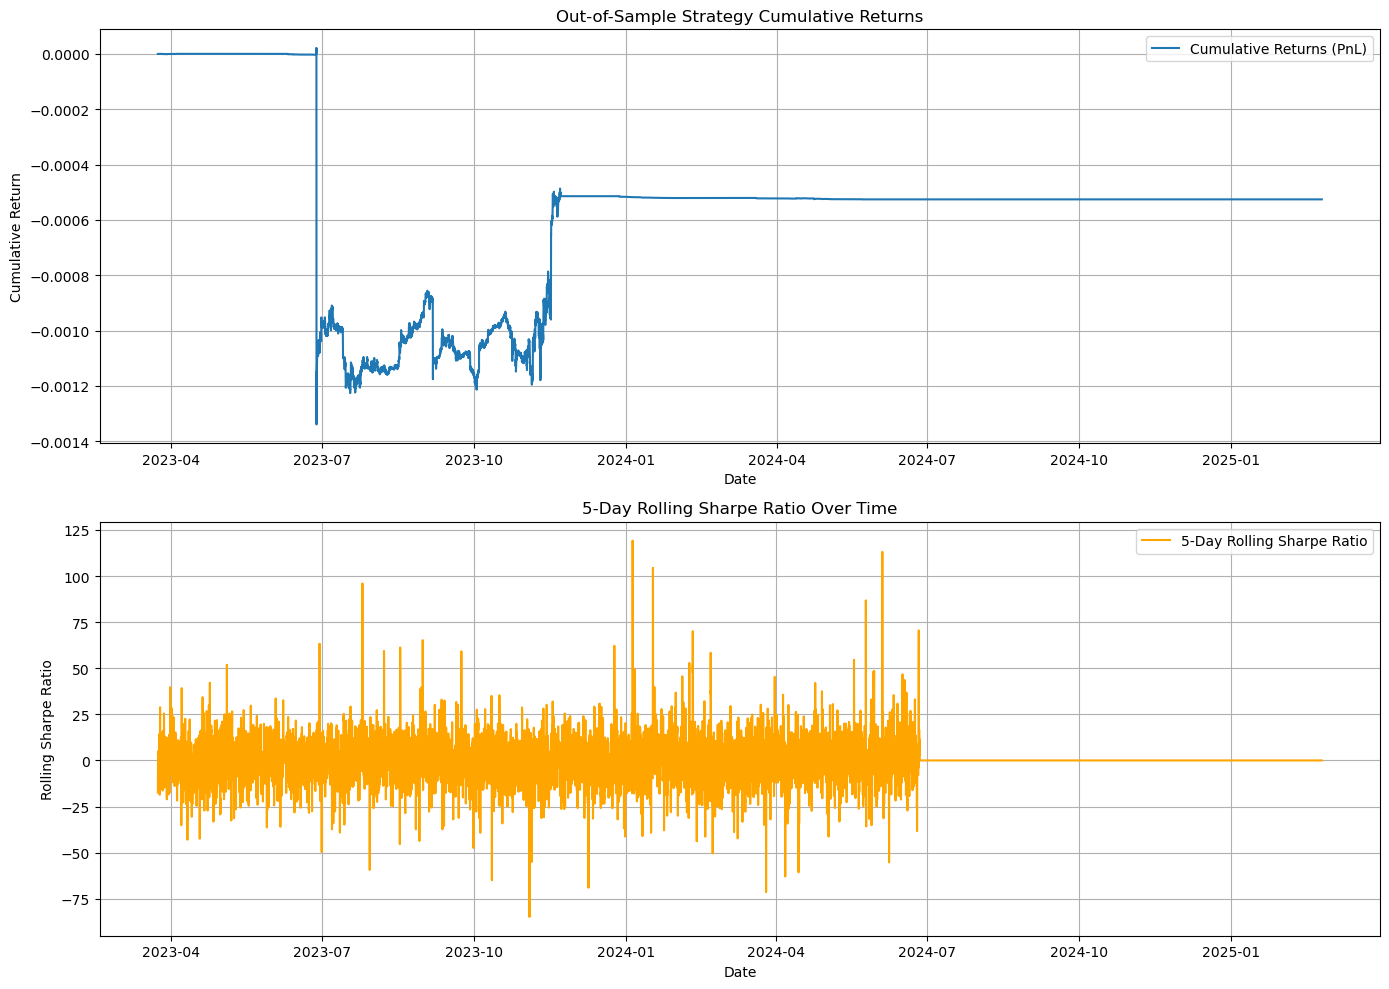

In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# --- Assumptions ---
# - feature_cols: list of feature column names used during training.
# - best_model: your trained model.
# - scaler and label_encoder: fitted on the training data.
# - data_2: out-of-sample DataFrame, which might be missing some feature columns (e.g., 'average_difficulty').

# Ensure that data_2 has all expected feature columns.
missing_features = [col for col in feature_cols if col not in data_2.columns]
if missing_features:
    print("Missing features in data_2:", missing_features)
    for col in missing_features:
        # You can fill with 0, or for example, with the mean of the training column if desired:
        # default_value = train_data[col].mean()
        default_value = 0
        data_2[col] = default_value

# Optionally, reindex data_2 to have the feature columns in the same order.
data_2 = data_2.reindex(columns=list(set(feature_cols).union(data_2.columns)), fill_value=0)

# ----- Prepare Out-of-Sample Data -----
# Extract features and target from data_2.
features_data2 = data_2[feature_cols].values
labels_data2 = data_2['Signal'].values

# Encode the target using the pre-fitted label_encoder and convert to categorical.
integer_encoded_data2 = label_encoder.transform(labels_data2)
y_data2 = to_categorical(integer_encoded_data2)

# Scale features using the pre-fitted scaler.
X_data2 = scaler.transform(features_data2)

# Evaluate classification performance on data_2.
loss_data2, accuracy_data2 = best_model.evaluate(X_data2, y_data2, verbose=0)
print("Out-of-Sample Classification Performance:")
print("  Test Loss: {:.4f}".format(loss_data2))
print("  Test Accuracy: {:.4f}".format(accuracy_data2))

# ----- Trading Performance Evaluation -----
# Compute asset returns using 'price_close'.
data_2 = data_2.copy()  # Avoid modifying the original DataFrame
data_2['asset_return'] = data_2['price_close'].pct_change()

# Drop NaNs resulting from the pct_change computation.
strategy_data2 = data_2.dropna().copy()

# Prepare features from the strategy_data and scale them.
features_data2_aligned = strategy_data2[feature_cols].values
X_data2_aligned = scaler.transform(features_data2_aligned)

# Get predictions on the out-of-sample aligned features.
y_pred_data2 = best_model.predict(X_data2_aligned)

# Create a trading signal:
# For instance, assume:
#   - Class 0 represents a long signal.
#   - Class 2 represents a short signal.
# We compute a position signal as: long probability minus short probability.
positions_data2 = y_pred_data2[:, 0] - y_pred_data2[:, 2]

# Compute the strategy returns.
# Shift positions by one period to avoid lookahead bias.
asset_returns_data2 = strategy_data2['asset_return'].values.astype(np.float32)
strategy_returns_data2 = np.roll(positions_data2, shift=1) * asset_returns_data2
strategy_returns_data2[0] = 0  # Set the first return to zero

# Compute cumulative returns.
cumulative_returns_data2 = np.cumprod(1 + strategy_returns_data2) - 1
total_pnl_percentage_data2 = cumulative_returns_data2[-1]

# Calculate absolute PnL given an initial capital.
initial_capital = 100000
absolute_pnl_data2 = total_pnl_percentage_data2 * initial_capital

# Calculate the annualized Sharpe ratio.
if np.std(strategy_returns_data2) != 0:
    sharpe_ratio_data2 = (np.mean(strategy_returns_data2) / np.std(strategy_returns_data2)) * np.sqrt(365)
else:
    sharpe_ratio_data2 = 0

print("\nOut-of-Sample Trading Performance:")
print("  Total PnL (percentage): {:.2%}".format(total_pnl_percentage_data2))
print("  Absolute PnL: ${:,.2f}".format(absolute_pnl_data2))
print("  Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_data2))

# ----- Visualization -----
dates = strategy_data2.index
cumulative_returns_series_data2 = pd.Series(cumulative_returns_data2, index=dates)
returns_series_data2 = pd.Series(strategy_returns_data2, index=dates)

window = 5
rolling_sharpe_data2 = returns_series_data2.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series_data2.index, cumulative_returns_series_data2, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Out-of-Sample Strategy Cumulative Returns')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe_data2.index, rolling_sharpe_data2, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
